In [1]:
#Load Modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import io
import requests
import pycountry
import math
NCountries = 0

In [2]:
def CreatePlots(df,key,tit, isLog=True, isReturn=False,x0=0):
    #Create ploys of a specified key, a logarithmic plot is possible
    v = df[key].values[0]
    if isLog:
        fig,axes = plt.subplots(2,1)
        axes[1].plot(v[x0:],marker='.',label=key)
        axes[1].set_title(tit+'-lograithmic')
        axes[1].set_yscale('log')
        axes[0].plot(v[x0:], marker='.',label=key)
        axes[0].set_title(tit+'-linear')
    else:
        axes,fig = plt.subplots(1,1)
        plt.plot(v[x0:], marker='.',label=key)
        plt.title(tit+'-linear')
    if isReturn:
        return axes
    #df.plot(y=key, marker = '.', ax=axes[0], title=tit+'-linear')
    #df.plot(y=key, marker = '.', ax=axes[1], title=tit+'-lograithmic', logy=True)

In [3]:
def AddMarksToPlot(axes,x,y,tit):
    #add markers at specified points
    if isinstance(axes,np.ndarray):
        for ax in axes:
            ax.scatter(x,y,color='r',zorder=0)
            for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))
    else:
        axes.scatter(x,y,marker='.',color='r',zorder=0)
        for xi,yi in zip(x,y):
                ax.annotate(tit,(xi,yi))

In [4]:
def AddExtremaToPlot(df,ax,key,d1Key,tol,MaxTit='maximum',MinTit='minimum'):
    indMax,indMin = FindExtrema(df,d1Key,tol)
    v = np.squeeze(np.array(df[key].values.tolist()))
    s = max(v.shape) - max(indMax.shape)
    temp = np.zeros(round(s/2),dtype=bool)
    indMax = np.concatenate((temp,indMax,temp))#Pad the indices with False from both sides
    #indMax = np.concatenate(([False],indMax,[False]))
    AddMarksToPlot(ax,np.argwhere(indMax),v[indMax],MaxTit)
    #indMin = np.concatenate(([False],indMin,[False]))
    indMin = np.concatenate((temp,indMin,temp))
    AddMarksToPlot(ax,np.argwhere(indMin),v[indMin],MinTit)

In [5]:
def rolling_window(a, window):
    #rolling window to smooth the data
    a = np.array(a)
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [6]:
def FindExtrema(df,d1key,tol,lim=5):
    #find zeros of given derivative, classify into maxima and minima, and return indinces
    d1val = np.array(df[d1key].values.tolist())
    indEx = abs(d1val) <= tol
    zero_crossingsMin = np.squeeze(np.array(np.where(np.diff(np.sign(d1val))>0)))
    zero_crossingsMax = np.squeeze(np.array(np.where(np.diff(np.sign(d1val))<0)))
    d2 = np.insert(np.squeeze(np.diff(d1val)),0,0)
    indMin = np.zeros(d1val.shape[1],dtype=bool)
    indMax = np.zeros(d1val.shape[1],dtype=bool)
    indMax[zero_crossingsMax] = True
    indMin[zero_crossingsMin] = True
    indMax = np.logical_and(indMax,abs(d2)>tol) 
    indMin = np.logical_and(indMin,abs(d2)>tol) 
    indMin[0:lim] = False#to avoid edge effects from initial noisy data
    indMax[0:lim] = False
    return indMax,indMin

In [7]:
def manager(df,tit,KeyList,isOrganize = True, isSum=True, isPlot=True):
    #Manages the organisation and reading of the data recieved from the repository
    if isOrganize:
        df = OrganizeDf(df, KeyList)
    if isSum:
        tot = pd.DataFrame(df.cases.tolist()).sum(0)
        df.loc[len(df.index)] = ['worldwide','worldwide',tot.values]
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], 'cases', tit)
    df = deriveatives(df, tit, isPlot)
    return df

In [8]:
def AddCountryCode(df,key='Country/Region'):
#insert alpha-3 code for each country
    def FindCountry(x):
        try:
            return pycountry.countries.lookup(x).alpha_3
        except:
            return x[0:3].upper()
    df['country-alpha3'] = df[key].apply(lambda x:FindCountry(x))
    return df

In [9]:
def deriveatives(df, tit, isPlot = True, key='cases',prefix=''):
    #Calculate first and second derivative and insert them into the dataframe with a specified prefix
    #v = np.array(df['cases'].values)
    #ind = df[key].isin([])
    cur_df = df[~df[key].isna()]# & ind]
    v = np.array(df[key].values.tolist())
    d1 = (v[:,2:] - v[:,0:-2])/2
    d2 = (v[:,2:] - 2*v[:,1:-1] + v[:,0:-2])
    d1str = prefix+'first_derivative'
    d2str = prefix+'second_derivative'
    df[d1str] = d1.tolist()
    df[d2str] = d2.tolist()
    if isPlot:
        CreatePlots(df[df['Country/Region']=='worldwide'], d1str, tit+'1st derivative',isLog=False)
        CreatePlots(df[df['Country/Region']=='worldwide'], d2str, tit+'2nd derivative',isLog=False)
    return df

In [10]:
def ewma_vectorized(data, alpha, offset=None, dtype=None, order='C', out=None):
    """
    Calculates the exponential moving average over a vector.
    Will fail for large inputs.
    :param data: Input data
    :param alpha: scalar float in range (0,1)
        The alpha parameter for the moving average.
    :param offset: optional
        The offset for the moving average, scalar. Defaults to data[0].
    :param dtype: optional
        Data type used for calculations. Defaults to float64 unless
        data.dtype is float32, then it will use float32.
    :param order: {'C', 'F', 'A'}, optional
        Order to use when flattening the data. Defaults to 'C'.
    :param out: ndarray, or None, optional
        A location into which the result is stored. If provided, it must have
        the same shape as the input. If not provided or `None`,
        a freshly-allocated array is returned.
    """
    data = np.array(data, copy=False)

    if dtype is None:
        if data.dtype == np.float32:
            dtype = np.float32
        else:
            dtype = np.float64
    else:
        dtype = np.dtype(dtype)

    if data.ndim > 1:
        # flatten input
        data = data.reshape(-1, order)

    if out is None:
        out = np.empty_like(data, dtype=dtype)
    else:
        assert out.shape == data.shape
        assert out.dtype == dtype

    if data.size < 1:
        # empty input, return empty array
        return out

    if offset is None:
        offset = data[0]

    alpha = np.array(alpha, copy=False).astype(dtype, copy=False)

    # scaling_factors -> 0 as len(data) gets large
    # this leads to divide-by-zeros below
    scaling_factors = np.power(1. - alpha, np.arange(data.size + 1, dtype=dtype),
                               dtype=dtype)
    # create cumulative sum array
    np.multiply(data, (alpha * scaling_factors[-2]) / scaling_factors[:-1],
                dtype=dtype, out=out)
    np.cumsum(out, dtype=dtype, out=out)

    # cumsums / scaling
    out /= scaling_factors[-2::-1]

    if offset != 0:
        offset = np.array(offset, copy=False).astype(dtype, copy=False)
        # add offsets
        out += offset * scaling_factors[1:]

    return out

In [11]:
def OrganizeDf(df, KeyList):
    #This function organizes the Dataframe, so that the dates won't be column names, 
    #and each row will be a country caontaining a vector of cases every day
    v = df[KeyList[4:]].values
    #if (v.shape[0] < NCountries - 1):
    #    temp = np.zeros((NCountries - v.shape[0],v.shape[1]))
    #    np.concatenate((v,temp),axis=0)
    #ind = df["Country/Region"].str.index("Kosovo")
    #print(v[ind,:])
    df['cases'] = v.tolist()
    df = df.drop(KeyList[4:],axis = 1)
    df = df.drop(['Lat','Long'], axis = 1)
    return df

In [12]:
def ShowData(df_current,key,d1key,d2key,tol1,tol2,isPlot1d=False,isPlot2d=False,tit='',AddValToGraph=False,AddValKey=''):
    #plot data, add markers, and plot derivatives if desired
    #in order to not display extremum markers, set tol1 or tol2 to infinity
    if tit=='':
        tit = key
    ax = CreatePlots(df_current, key, tit,isReturn=True)
    AddExtremaToPlot(df_current,ax,key,d1key,tol1)#plot 1st derivative
    AddExtremaToPlot(df_current,ax,key,d2key,tol2,MaxTit='inflection',MinTit='inflection')#plot 2nd derivative
    if AddValToGraph:
        val = df_current[AddValKey].values
        v=np.array([val[0]]*2)#np.ones(np.shape(df_current[key].values))*val[0]
        if isinstance(ax,np.ndarray):
            for a in ax:
                x = a.get_xlim()
                a.plot(x,v,linestyle='--',color='r',label=AddValKey)
                a.legend()
        else:
            x = ax.get_xlim()
            ax.plot(x,v,linestyle='--',color='r',label=AddValKey)
    if isPlot1d:
        CreatePlots(df_current, d1key, tit+" first derivative",isReturn=False,isLog=False)
    if isPlot2d:
        CreatePlots(df_current, d2key, tit+" second derivative",isReturn=False,isLog=False)

In [13]:
#get the data and create data frames
url_confirm = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_dead ='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recover='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
urls = [url_confirm,url_dead,url_recover]
NewKeys = ['confirmed','dead','recovered']#names of keys
PlotTitle = ['confirmed','dead','recovered']#titles of plots corresponding to the data
NCountries=0

for i,u in enumerate(urls):
    temp_df = pd.read_csv(u)
    KeyList = temp_df.keys()
    temp_df = manager(temp_df, PlotTitle[i], KeyList, isOrganize = True, isSum=True, isPlot=False)
    if i==0:
        d1 = datetime.strptime(KeyList[4], "%m/%d/%y")
        d2 = datetime.strptime(KeyList[-1], "%m/%d/%y")
        NDays = abs((d2 - d1).days)
        NCountries = len(temp_df.index)
        dateVec = KeyList[4:]
        df = temp_df
    else:
        df = pd.merge(df,temp_df,how='outer',on=['Country/Region',"Province/State"])
    df = df.rename(columns={"cases":NewKeys[i]+'_cases'})
    df = df.rename(columns={"first_derivative":NewKeys[i]+'_first_derivative'})
    df = df.rename(columns={"second_derivative":NewKeys[i]+'_second_derivative'})

DataTagsList = ['confirm_df','dead_df','recover_df']
df = df.drop(df.index[-1])

In [14]:
print(df.shape)
df.tail()

(259, 11)


,Province/State,Country/Region,confirmed_cases,confirmed_first_derivative,confirmed_second_derivative,dead_cases,dead_first_derivative,dead_second_derivative,recovered_cases,recovered_first_derivative,recovered_second_derivative
254,NaN,Burundi,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
255,NaN,Sierra Leone,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
256,"Bonaire, Sint Eustatius and Saba",Netherlands,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
257,NaN,Malawi,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
258,worldwide,worldwide,"[555, 654, 941, 1434, 2118, 2927, 5578, 6166, ...","[193.0, 390.0, 588.5, 746.5, 1730.0, 1619.5, 1...","[188, 206, 191, 125, 1842, -2063, 1480, -375, ...","[17, 18, 26, 42, 56, 82, 131, 133, 171, 213, 2...","[4.5, 12.0, 15.0, 20.0, 37.5, 25.5, 20.0, 40.0...","[7, 8, -2, 12, 23, -47, 36, 4, 4, 57, -39, 2, ...","[28, 30, 36, 39, 52, 61, 107, 126, 143, 222, 2...","[4.0, 4.5, 8.0, 11.0, 27.5, 32.5, 18.0, 48.0, ...","[4, -3, 10, -4, 37, -27, -2, 62, -17, 126, -37..."


In [15]:
#Calculate active cases and add them to the dataframe
tol = 10#tolerance used for finding extrema and inflection points

for row in df.loc[df.recovered_cases.isnull(), 'recovered_cases'].index:#clear from NaN
    df.at[row, 'recovered_cases'] = [0]*(NDays+1)

active_temp = np.stack(df['confirmed_cases'].to_numpy())- np.stack(df['dead_cases'].to_numpy()) - np.stack(df['recovered_cases'].to_numpy())

df['active_cases'] = active_temp.tolist()
df = deriveatives(df, 'active cases', isPlot = False, key='active_cases',prefix='active_')
worldwide = df[df['Country/Region']=='worldwide']

In [16]:
#Find point for 100th patient
def FindPatient(x,num=100):
    x=np.array(x)
    if max(x)<=100:
        num = 0
    ind = np.where(x.ravel()>=num)
    return ind[0][0]
df['start_index'] = df['confirmed_cases'].apply(lambda x:FindPatient(x,num=100))

In [17]:
df[df['Country/Region']=='US']

,Province/State,Country/Region,confirmed_cases,confirmed_first_derivative,confirmed_second_derivative,dead_cases,dead_first_derivative,dead_second_derivative,recovered_cases,recovered_first_derivative,recovered_second_derivative,active_cases,active_first_derivative,active_second_derivative,start_index
225,NaN,US,"[1, 1, 2, 2, 5, 5, 5, 5, 5, 7, 8, 8, 11, 11, 1...","[0.5, 0.5, 1.5, 1.5, 0.0, 0.0, 0.0, 1.0, 1.5, ...","[1, -1, 3, -3, 0, 0, 0, 2, -1, -1, 3, -3, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 2, 2, 5, 5, 5, 5, 5, 7, 8, 8, 11, 11, 1...","[0.5, 0.5, 1.5, 1.5, 0.0, 0.0, 0.0, 1.0, 1.5, ...","[1, -1, 3, -3, 0, 0, 0, 2, -1, -1, 3, -3, 0, 0...",41


In [18]:
#Smoothing active cases
def SmoothKey(df,key,newKeyName,alpha):#AverageRow(row):
    df[newKeyName]=df.apply(lambda row: ewma_vectorized(np.array(row[key]), alpha, offset=row['start_index'])
                            ,axis=1)
    df = deriveatives(df, '', isPlot = False, key=newKeyName,prefix=newKeyName+'_')
    return df
    #return ewma_vectorized(np.array(row['active_cases']), alpha, offset=row['start_index'])
alpha=0.1
df = SmoothKey(df,'active_cases','smooth_active',alpha)
df = SmoothKey(df,'confirmed_cases','smooth_confirmed',alpha)

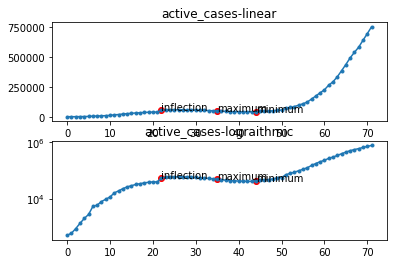

In [19]:
worldwide = df[df['Country/Region']=='worldwide']
ShowData(worldwide,'active_cases','smooth_active_first_derivative','smooth_active_second_derivative',10,1000,tit='')

# Tests 
Add Number of tests in each country(where data is available)

In [20]:
def FixCountryName(name):
    x=name.split(':')
    x = x[0].split('(')
    return x[0]

link = "https://en.wikipedia.org/wiki/Template:COVID-19_testing"

WikiTable = pd.read_html(link,header=0)
WikiTable = WikiTable[0]
WikiTable['Country'] = WikiTable['Country or region'].apply(lambda x: FixCountryName(x))
WikiTable = AddCountryCode(WikiTable,key='Country')
WikiTable = WikiTable.drop_duplicates(subset='Country',keep='first')
df = AddCountryCode(df)

df = pd.merge(df,WikiTable[['country-alpha3','Tests','Tests /millionpeople']],how='left',on=['country-alpha3'])
df = df.rename(columns={"Tests": "Tests(Nationwide)",'Tests /millionpeople':'Tests /millionpeople(Nationwide)'})
df['Tests(Nationwide)'] = df['Tests(Nationwide)'].fillna(0)
df['Tests /millionpeople(Nationwide)'] = df['Tests /millionpeople(Nationwide)'].fillna(0)

# Number of beds
We will add the number of hospital beds in each country(where data is available), and also numer of cases releative to number of beds in the country

In [22]:
#load number of beds from csv
url = 'HospitalBedsOECD.csv'
temp_df = pd.read_csv(url)
temp_df = temp_df[temp_df['Variable']=='Curative (acute) care beds']
temp_df = temp_df.drop_duplicates(subset=['COU','Measure'],keep='last')#fix country name to match my dataframe
temp_df = temp_df.rename(columns={"COU": "country-alpha3"})
#bed number
bed_df = temp_df[temp_df['Measure']=='Number']
#bed number relative to population size
bed_density_df = temp_df[temp_df['Measure']=='Per 1 000 population']
bed_df = bed_df.rename(columns={'Value':'Hospital_beds(Nationwide)'})
bed_density_df = bed_density_df.rename(columns={'Value':'Hospital_beds_density(Nationwide)'})
#merge into the dataframe
df = pd.merge(df,bed_df[['country-alpha3','Hospital_beds(Nationwide)']],how='left',on=['country-alpha3'])
df = pd.merge(df,bed_density_df[['country-alpha3','Hospital_beds_density(Nationwide)']],how='left',on=['country-alpha3'])
#add cases relative to number of beds
# keys = ['confirmed_cases','active_cases']
# for k in keys:
#     beds_temp = np.stack(df[k])/df['Hospital_beds(Nationwide)'].values.to_numpy()
#     df[k + '_per_beds'] = beds_temp.to_list()#df[k].to_numpy()/df['Hospital_beds(Nationwide)']#df.apply(lambda row:row[k]/row['Hospital_beds(Nationwide)'])

KeyError: 'Hospital_beds(Nationwide)'

In [ ]:
df.tail()

In [ ]:
#countries
CList = ['Israel']#,'Italy','Korea, South','Israel','US','Japan']
keyList = df.keys()
keyList = keyList[2:]
#df[['active_cases','confirmed_cases','dead_cases','recovered_cases']].groupby('Country/Region')
for c in CList:
    temp_df = df[df['Country/Region']==c]
    country_df = temp_df.iloc[[0]]
    country_df['Province/State']='all'
    #country_df = country_df.groupby(['Country/Region'],as_index=False)
    #print(country_df.head())
    for k in keyList:
        tot = pd.DataFrame(temp_df[k].tolist()).sum(0)
        country_df[k] = [tot.values.tolist()]
    #df.loc[-1] = ['worldwide','worldwide',tot.values]
    #
    ShowData(country_df,'confirmed_cases','confirmed_first_derivative','confirmed_second_derivative',10,1000,isPlot1d=True,isPlot2d=True,tit=c+' confirmed cases')#,AddValToGraph=True,AddValKey='Hospital_beds(Nationwide)')
    #ShowData(country_df,'smooth_confirmed','smooth_confirmed_first_derivative','smooth_confirmed_second_derivative',10,500,isPlot1d=True,isPlot2d=True,tit=c+' confirmed cases',AddValToGraph=True,AddValKey='Hospital_beds(Nationwide)')

In [ ]:
df[df['Country/Region']=='China']